<a href="https://colab.research.google.com/github/samleonnn/HerAi-Model-Development/blob/main/WasteSegregation_TransferLearning_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ProjectSecret/AllMainData_v2.zip", "r")
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
TRAIN_DIR = "/tmp/AllMainData/TRAIN"
VAL_DIR  = "/tmp/AllMainData/VAL"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, 
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, 
                                   horizontal_flip = True)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DIR,
                                    batch_size=128, 
                                    class_mode="categorical",
                                    target_size=(299, 299))

# Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
# Remember that validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.5)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(299, 299),
                                            subset = "training",
                                            shuffle = False)

test_generator = validation_datagen.flow_from_directory(directory=VAL_DIR,
                                            batch_size=128, 
                                            class_mode="categorical",
                                            target_size=(299, 299),
                                            subset = "validation",
                                            shuffle = False)

Found 31500 images belonging to 3 classes.
Found 3212 images belonging to 3 classes.
Found 3211 images belonging to 3 classes.


In [ ]:
print(train_generator.class_indices)

{'Non-Recyclable': 0, 'Organic': 1, 'Recyclable': 2}


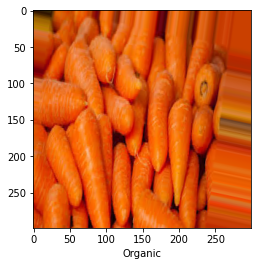

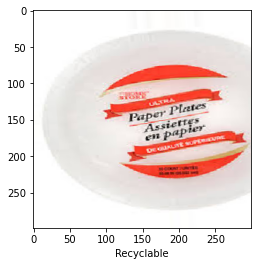

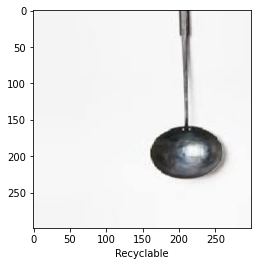

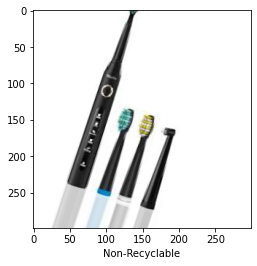

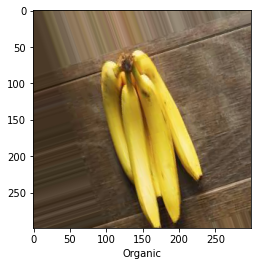

In [ ]:
class_names = ["Non-Recyclable", "Organic", "Recyclable"]
x,y = train_generator.next()

for i in range(5):
    image = x[i]
    label = np.argmax(y[i])
    plt.xlabel(class_names[label])
    plt.imshow(image)
    plt.show()

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(299, 299, 3),
                          pooling='avg')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
last_layer = pre_trained_model.get_layer('block13_sepconv2_act')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 19, 19, 728)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(3, activation='softmax')(x)           

model = tf.keras.Model(pre_trained_model.input, x) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
opt = "adam"

model.compile(optimizer=opt,
            loss="categorical_crossentropy",
            metrics=['accuracy']) 

In [ ]:
history = model.fit(train_generator,
                    epochs = 10,
                    verbose = 1,
                    validation_data = validation_generator)

Epoch 1/10
247/247 [==============================] - 772s 3s/step - loss: 1.0663 - accuracy: 0.7742 - val_loss: 0.3978 - val_accuracy: 0.8378
Epoch 2/10
247/247 [==============================] - 741s 3s/step - loss: 0.3634 - accuracy: 0.8546 - val_loss: 0.3506 - val_accuracy: 0.8462
Epoch 3/10
247/247 [==============================] - 733s 3s/step - loss: 0.3363 - accuracy: 0.8695 - val_loss: 0.3585 - val_accuracy: 0.8559
Epoch 4/10
247/247 [==============================] - 743s 3s/step - loss: 0.3276 - accuracy: 0.8703 - val_loss: 0.3406 - val_accuracy: 0.8496
Epoch 5/10
247/247 [==============================] - 743s 3s/step - loss: 0.3071 - accuracy: 0.8780 - val_loss: 0.3389 - val_accuracy: 0.8633
Epoch 6/10
247/247 [==============================] - 730s 3s/step - loss: 0.2854 - accuracy: 0.8887 - val_loss: 0.3574 - val_accuracy: 0.8453
Epoch 7/10
247/247 [==============================] - 732s 3s/step - loss: 0.2767 - accuracy: 0.8924 - val_loss: 0.3373 - val_accuracy: 0.8671

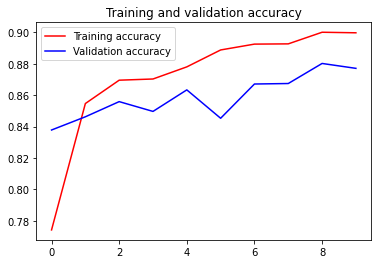

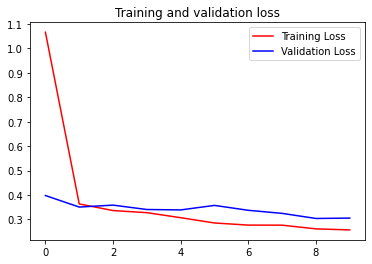

In [ ]:
# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_generator)

26/26 [==============================] - 29s 1s/step - loss: 0.1466 - accuracy: 0.9455


[0.14658044278621674, 0.945499837398529]

Confusion Matrix


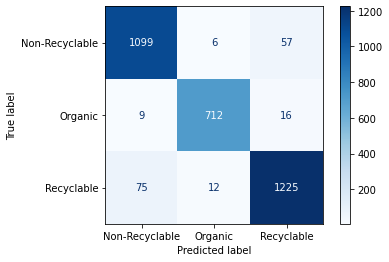


Classification Report
                precision    recall  f1-score   support

Non-Recyclable       0.93      0.95      0.94      1162
       Organic       0.98      0.97      0.97       737
    Recyclable       0.94      0.93      0.94      1312

      accuracy                           0.95      3211
     macro avg       0.95      0.95      0.95      3211
  weighted avg       0.95      0.95      0.95      3211



In [ ]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ["Non-Recyclable", "Organic", "Recyclable"]
cm = confusion_matrix(test_generator.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

print()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))   